In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# read in the MPRA data
data = pd.read_csv("MPRA_data_2025.txt", sep='\t', header=None)
# rename the columns
data.columns = ['sequence', 'expression']
# set up the label binarizer from sklearn
lb = LabelBinarizer()
lb.fit(list('ACGT'))
# function for one hot encoding the data
def one_hot_encode(sequence):
    return lb.transform(list(sequence))
# one hot encode the sequence
data['ohc_sequence'] = data['sequence'].apply(one_hot_encode) # this line is using the pandas apply function to run the one_hot_encode function on each row of the dataframe
# preview result
print("Preprocessed data preview: ")
print(data.head())

Preprocessed data preview: 
                                            sequence  expression  \
0  CTCCGGCCCTATGCAATCGAGTTATTGCGAGTGCGTTATTGGGAAC...       0.555   
1  ATTCAAATCTTACTTTTCAGTATAGGAGTTTCTTGCGTAAACTGCT...       0.560   
2  TTGGTCCGGGGCTGACACCCCACCCACCGAAAGAGGCTGCACCAAA...       0.335   
3  TGAAGTTTGCAATAGAACCAGTCAAGATGGTTTCCCTAAAGATAGC...       0.655   
4  TGGGGGGAAGGTTTGGCTTAGGGTACGGGGTTAACAGTTTACAACG...       0.485   

                                        ohc_sequence  
0  [[0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0,...  
1  [[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0,...  
2  [[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0,...  
3  [[0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1,...  
4  [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0,...  


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# split the data into X and y
X = np.stack(data['ohc_sequence'])
y = data['expression'].values

# split the data into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=24)

# save the data (if you are working on google colab your variables work across cells so you don't technically need to save the data, you can just use the variables in the next cell)
# however if you run into problems it will be easier for the instructor to help you if you have saved the data
#np.save('X_train.npy', X_train)
#np.save('X_val.npy', X_val)
#np.save('X_test.npy', X_test)
#np.save('y_train.npy', y_train)
#np.save('y_val.npy', y_val)
#np.save('y_test.npy', y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
def create_simple_nn():
  input_shape = (200, 4)

  simple_nn = Sequential([
      Flatten(input_shape=input_shape),   # Flatten the input
      Dense(512, activation='relu'),      # Fully connected layer with 512 units
      Dense(256, activation='relu'),       # Fully connected layer with 256 units
      Dense(1)                            # Output layer with 1 unit (for regression)
  ])

  return simple_nn

In [ ]:
#Enable GPU (Runtime->Change runtime type -> GPU)
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
simple_nn = create_simple_nn()
simple_nn.summary()
simple_nn.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-2), loss='mse')

# Setup callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_simple_nn_model.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
history = simple_nn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1024, callbacks=[checkpoint], verbose=1)

# Evaluate the model
# Load the best weights
simple_nn.load_weights('best_simple_nn_model.weights.h5')
y_pred = simple_nn.predict(X_test)

# Print the R2 score
r2= r2_score(y_test, y_pred)
print("R2 score (simple Neural Network): ", r2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         410,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 541,697 (2.07 MB)

 Trainable params: 541,697 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2301
Epoch 1: val_loss improved from inf to 0.08499, saving model to best_simple_nn_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 0.2196 - val_loss: 0.0850
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0826
Epoch 2: val_loss improved from 0.08499 to 0.06540, saving model to best_simple_nn_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0770 - val_loss: 0.0654
Epoch 3/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0607
Epoch 3: val_loss improved from 0.06540 to 0.05727, saving model to best_simple_nn_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0602 - val_loss: 0.0573
Epoch 4/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0535
Epoch 4: val_loss improved from 0.05727 to 0.05315, saving model to best_simple_nn_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0532 - val_loss: 0.0531
Epoch 5/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error, r2_score

def create_CNN_model():
    model = Sequential([
    Conv1D(filters=32, kernel_size=17, activation='relu', input_shape=(X_train.shape[1], 4)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=17, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
  ])
    return model

# Create the model
CNN_model = create_CNN_model()
CNN_model.summary()
CNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), loss='mse')

# Set up callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_CNN_model.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
CNN_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1024, callbacks=[checkpoint], verbose=1)

# Evaluate the model
# Load the best weights
CNN_model.load_weights('best_CNN_model.weights.h5')
y_pred = CNN_model.predict(X_test)

# Print the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score (Conv Neural Network): ", r2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 184, 32)             │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 92, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 76, 64)              │          34,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         155,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,865 (753.38 KB)

 Trainable params: 192,865 (753.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - loss: 0.2991
Epoch 1: val_loss improved from inf to 0.05733, saving model to best_CNN_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 732ms/step - loss: 0.2833 - val_loss: 0.0573
Epoch 2/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0702
Epoch 2: val_loss improved from 0.05733 to 0.05321, saving model to best_CNN_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0738 - val_loss: 0.0532
Epoch 3/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0458 
Epoch 3: val_loss improved from 0.05321 to 0.02746, saving model to best_CNN_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0413 - val_loss: 0.0275
Epoch 4/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0266
Epoch 4: val_loss improved from 0.02746 to 0.02668, saving model to best_CNN_model.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0271 - val_loss: 0.0267
Epoch 5/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0227
Epoch 5: val_loss

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create the model
reg = LinearRegression().fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluate the model
y_pred = reg.predict(X_test.reshape(X_test.shape[0], -1))
# Save predictions to an npy file
np.save('y_pred_linearRegressor.npy', y_pred)
# Print the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score: ", r2)

R2 score:  1.0


In [ ]:
import h5py
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import h5 data
with h5py.File("scRNA_counts_2025.h5", 'r') as f:
    X = f['X'][:]
print(X[:5])

X = StandardScaler().fit_transform(X)
# Perform PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

# perform t-SNE
perplexity = 40 # Note that the perplexity is a hyperparameter that you can tune, you should look into what it does and how to tune it
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
X_tsne = tsne.fit_transform(X)

[[ 5  0  8 ...  0  9 19]
 [ 1  0  2 ...  0  3 27]
 [ 4  2 19 ...  0  0 32]
 [ 5  0 19 ...  0  0 15]
 [ 0  0  7 ...  0  7 34]]


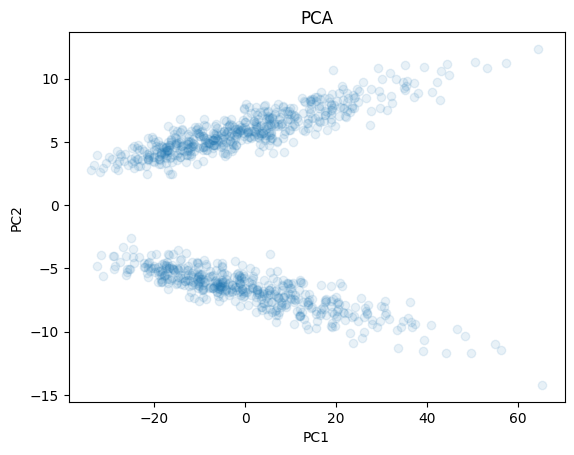

In [ ]:
import matplotlib.pyplot as plt
# Plot the PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
labels_kmeans = kmeans.labels_


In [ ]:
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=2)
labels_agglomerative = agglomerative.fit_predict(X_pca)

In [ ]:
from sklearn.cluster import DBSCAN
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1).fit(X_pca)
labels_dbscan = dbscan.labels_

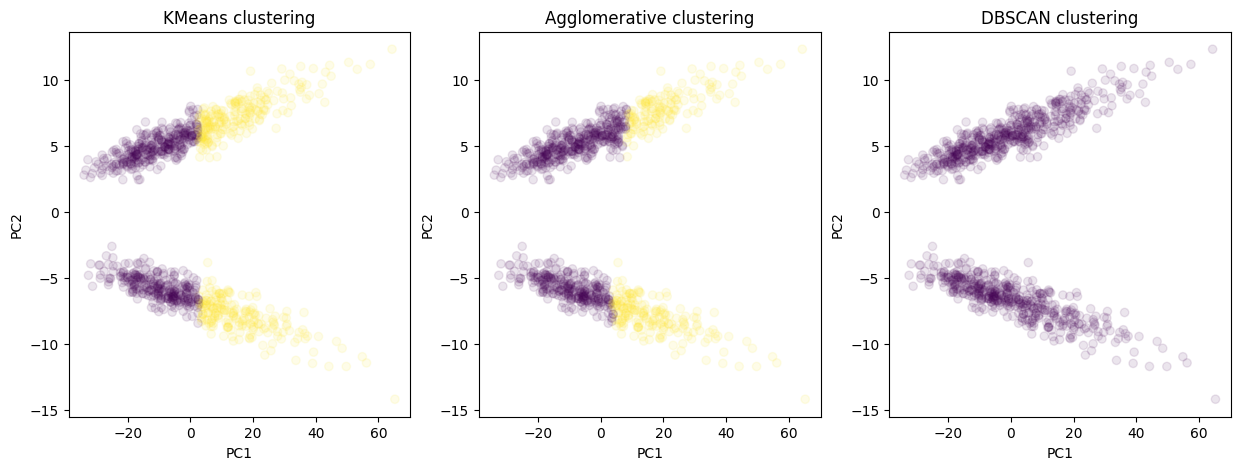

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, alpha=0.1)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('KMeans clustering')
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_agglomerative, alpha=0.1)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('Agglomerative clustering')
ax[2].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, alpha=0.1)
ax[2].set_xlabel('PC1')
ax[2].set_ylabel('PC2')
ax[2].set_title('DBSCAN clustering')
plt.show()

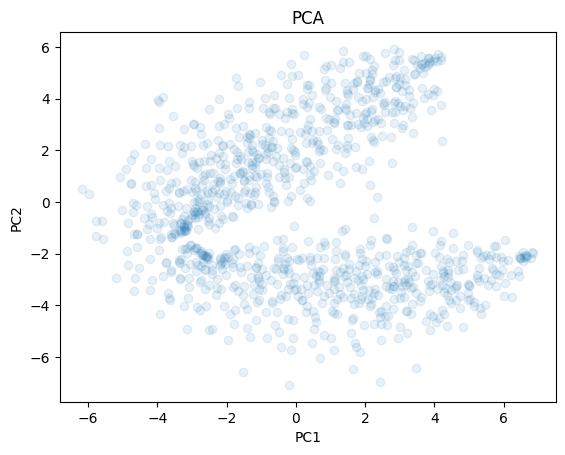

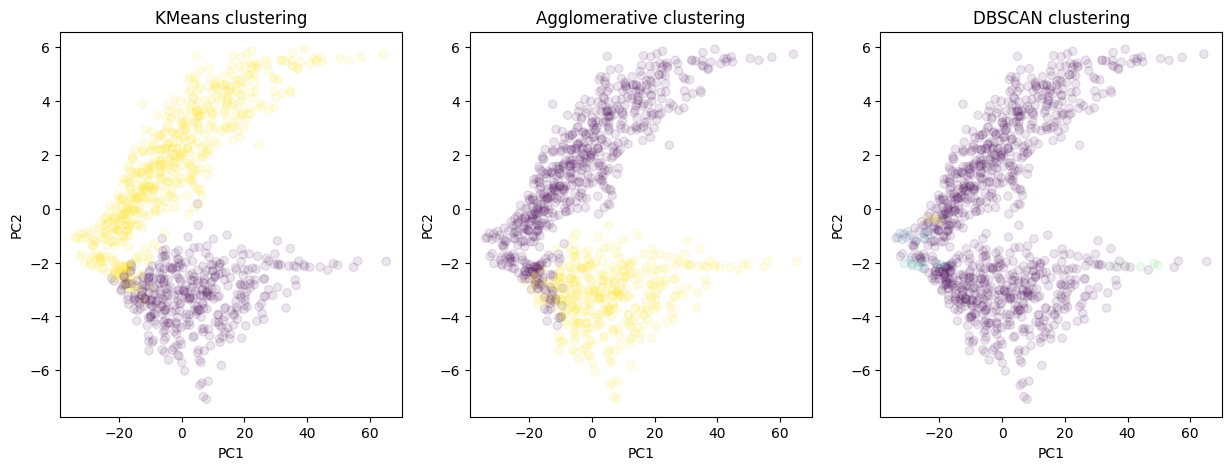

In [ ]:
import matplotlib.pyplot as plt
# Plot the PCA
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()



from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_tsne)
labels_kmeans = kmeans.labels_



from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=2)
labels_agglomerative = agglomerative.fit_predict(X_tsne)



from sklearn.cluster import DBSCAN
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1).fit(X_tsne)
labels_dbscan = dbscan.labels_



fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_pca[:, 0], X_tsne[:, 1], c=labels_kmeans, alpha=0.1)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('KMeans clustering')
ax[1].scatter(X_pca[:, 0], X_tsne[:, 1], c=labels_agglomerative, alpha=0.1)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('Agglomerative clustering')
ax[2].scatter(X_pca[:, 0], X_tsne[:, 1], c=labels_dbscan, alpha=0.1)
ax[2].set_xlabel('PC1')
ax[2].set_ylabel('PC2')
ax[2].set_title('DBSCAN clustering')
plt.show()